In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['shinzo-abe-japanese-prime-minister-twitter-nlp', 'ja-nlp']


In [ ]:
!pip install openpyxl

In [ ]:
import openpyxl

In [ ]:
!pip install nltk

In [ ]:
!pip install spacy

In [ ]:
import spacy


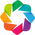

In [39]:
import os
import datetime
import codecs
import re
import warnings
warnings.filterwarnings('ignore')
import pkg_resources, imp
imp.reload(pkg_resources)
import numpy as np
import pandas as pd
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from matplotlib import pyplot as plt
# import neologdn
# import nltk
# from nltk.corpus import stopwords
# nltk.download('vader_lexicon')
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import spacy
from spacy.lang.ja import Japanese
import regex
from wordcloud import WordCloud
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
# import shap
# shap.initjs()
# import oseti

In [3]:
import os
os.getcwd()
print(os.getcwd())

/kaggle/working


In [4]:
# use janome tokenizer
import re
import itertools
import unicodedata
from janome.tokenizer import Tokenizer
import networkx as nx
from scipy.spatial import distance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Droid Sans Japanese'

In [47]:
# Load the dataset into a pandas dataframe.
import pandas as pd
# df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
col_list=[10,11,15,16]
df = pd.read_excel("/kaggle/input/ja-nlp/ja_slide9_data.xlsx", usecols=col_list,names=['sentence1','sentence2','sentence3','sentence4'])
# col_list=[15]
# df = pd.read_excel("/kaggle/input/ja-nlp/ja_slide9_data.xlsx", usecols=col_list,names=['sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
# df.sample(5)
df.head(5)

Number of training sentences: 133



,sentence1,sentence2,sentence3,sentence4
0,アクション時に活かす,大変タイムリーな内容でありがたい,もっとベタニスベオーバを学ぶ,現場のアクションに活かす
1,飲み忘れ血中濃度DSP,NaN,特になし,NaN
2,DRRの根本として薬剤特性訴求コンテンツを活用,NaN,他剤理解しTOV継続訴求,NaN
3,患者さんの為に,NaN,不安は無いです,NaN
4,ARISTOTLE優越性訴求コンテンツ,NaN,インサイトの深堀が重要であることは着任時から重要と思い指導している。しかし、現場で出来ている...,いつもわかりやすく素晴らしいトレーニングありがとうございます。


In [54]:
vertical_concat = pd.concat([df['sentence1'],df['sentence2'],df['sentence3'],df['sentence4']], axis=0)
print("The total number of text data：\t"+str(len(vertical_concat)))

The total number of text data：	532


In [55]:
df_delna = vertical_concat.dropna()
print("After deleting nan, the rest number of text data：\t"+str(len(df_delna)))

After deleting nan, the rest number of text data：	334


In [57]:
# tokenize, find noun/verb/adj

tweets=df_delna.as_matrix()
# tweets = df['sentence'].as_matrix()
# tweets=df['sentence1'].as_matrix()+df['sentence2'].as_matrix()
# tweets = df['sentence1'].as_matrix()
regex = u'[^\u3041-\u3093\u30A1-\u30F4\u4E00-\u9FCB]'
t = Tokenizer()
tweet_words = []
for tweet in tweets:
    tweet = re.sub(regex, ' ', tweet)
    words = []
    for token in t.tokenize(tweet):
        speechs = token.part_of_speech.split(',')
        if ('名詞' in speechs) or ('形容詞' in speechs) or ('動詞' in speechs):
            if len(token.surface) > 1:
                words.append(token.surface)
    tweet_words.append(words)
# len(tweet_words)

### one-unit word frequency

In [98]:
word_cnt = {}
for words in tweet_words:
    for word in words:
        if word not in word_cnt:
            word_cnt[word] = 1
        else:
            word_cnt[word] += 1
    
word_cnt_df = pd.DataFrame({'word': [k for k in word_cnt.keys()], 'cnt': [v for v in word_cnt.values()]})
len(word_cnt_df)
word_cnt_df.sort_values(by='cnt', ascending=False).head(10)

,cnt,word
8,55,訴求
10,44,活用
36,43,する
9,38,コンテンツ
37,35,思い
56,35,動画
24,30,先生
6,24,薬剤
7,24,特性
27,23,いき


In [99]:
word_cnt_df[['cnt']].describe()

,cnt
count,733.000000
mean,2.858117
std,5.066935
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,55.000000


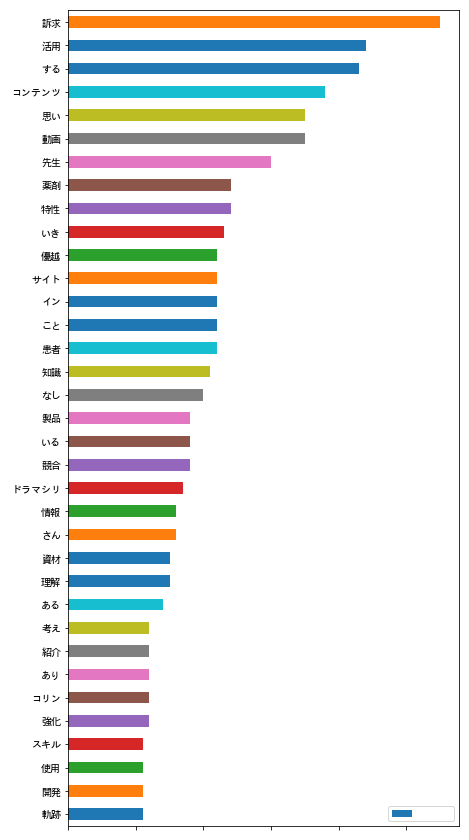

In [63]:
tmp = word_cnt_df[word_cnt_df['cnt'] > 10]
# tmp.sort_values(by='cnt', ascending=False).plot(kind='bar', x='word', y='cnt', figsize=(15,7), legend=False)
tmp.sort_values(by='cnt', ascending=True).plot.barh( x='word', y='cnt',figsize=(7,15))
plt.show()

### two-unit word frequency

In [64]:
# tweet_words
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

one_word_list=flatten_list(tweet_words)
# print(one_word_list)

In [65]:
from itertools import permutations
# list_test=keysList
word_2=permutations(one_word_list,2)
two_unit_list = [''.join(i) for i in word_2]
# print(two_unit_list)

In [86]:
# sentences = df.sentence.values
sentences=df_delna.values
# print(sentences[5])
col15_sentence=[]
for sen in sentences:
    col15_sentence.append(sen)
col15_sentence_text='.'.join(col15_sentence)

def unit2_dictionary(str,word_list):
    counts = dict()
    for word in word_list:
        dic=str.count(word)
        # counts[word] =dic
        if dic!=0:
            counts[word] =dic
    return counts
unit2_dic=unit2_dictionary(col15_sentence_text,two_unit_list)
# print(unit2_dic)

In [91]:
dict1 = unit2_dic
sorted_dict = {}
sorted_keys = sorted(dict1, key=dict1.get,reverse=True)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = dict1[w]
# print(sorted_dict) 

In [92]:
two_word_cnt_df = pd.DataFrame({'two_word': [k for k in sorted_dict.keys()], 'two_word_freq': [v for v in sorted_dict.values()]})
len(two_word_cnt_df)
two_word_cnt_df.head(10)

,two_word,two_word_freq
0,訴求コンテンツ,28
1,インサイト,22
2,薬剤特性,20
3,ドラマシリ,17
4,特性訴求,15
5,患者さん,15
6,紹介する,8
7,活用する,7
8,香坂先生,7
9,製品知識,6


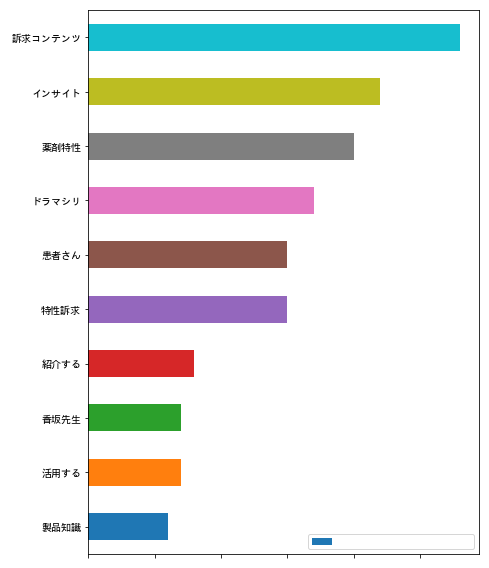

In [93]:
tmp2 = two_word_cnt_df[two_word_cnt_df['two_word_freq'] > 5]
# tmp2.sort_values(by='two_word_freq', ascending=False).plot(kind='bar', x='two_word', y='two_word_freq', figsize=(15,7), legend=False)
tmp2.sort_values(by='two_word_freq', ascending=True).plot.barh( x='two_word', y='two_word_freq',figsize=(7,10),legend=True)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b64129048>,
      dtype=object)

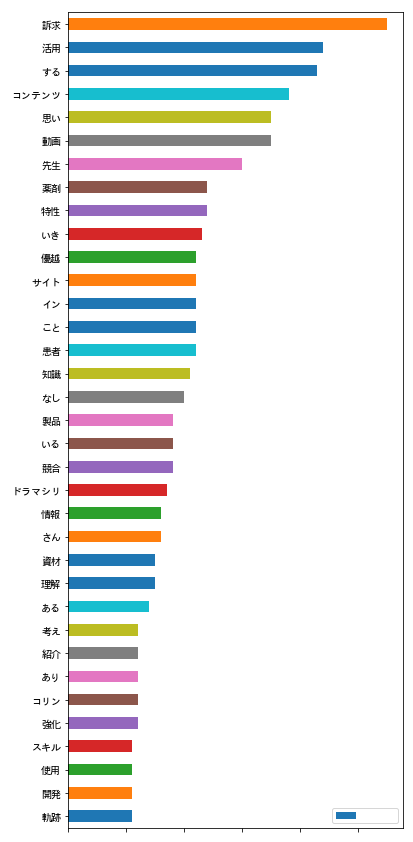

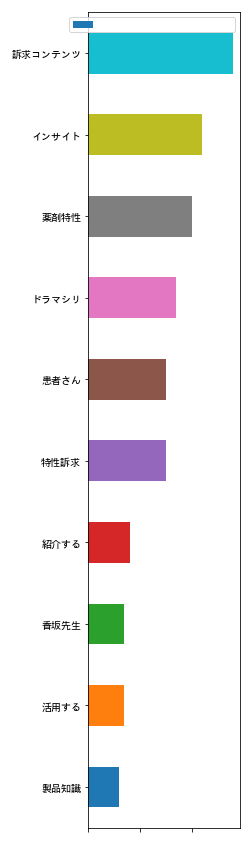

In [94]:
fig=plt.figure()
# ax1=fig.add_subplot(121)
tmp.sort_values(by='cnt', ascending=True).plot.barh( x='word', y='cnt',figsize=(6,15),subplots=True, layout=(1, 1), sharex=False)
# ax2=fig.add_subplot(122)
tmp2.sort_values(by='two_word_freq', ascending=True).plot.barh( x='two_word', y='two_word_freq',figsize=(6,15),subplots=True, layout=(1, 2), sharex=False)



### co-occurrence network

In [107]:
vocab = {}
# target_words = word_cnt_df[word_cnt_df['cnt'] > 3]['word'].as_matrix()
target_words = word_cnt_df[word_cnt_df['cnt'] > 5]['word'].as_matrix()
for word in target_words:
    if word not in vocab:
        vocab[word] = len(vocab)

re_vocab = {}
for word, i in vocab.items():
    re_vocab[i] = word
    
len(vocab)

78

In [108]:
tweet_combinations = [list(itertools.combinations(words, 2)) for words in tweet_words]
combination_matrix = np.zeros((len(vocab), len(vocab)))

for tweet_comb in tweet_combinations:
    for comb in tweet_comb:
        if comb[0] in target_words and comb[1] in target_words:
            combination_matrix[vocab[comb[0]], vocab[comb[1]]] += 1
            combination_matrix[vocab[comb[1]], vocab[comb[0]]] += 1
        
for i in range(len(vocab)):
    combination_matrix[i, i] /= 2
        
combination_matrix

array([[ 1., 23., 24., ...,  0.,  1.,  0.],
       [23.,  1., 22., ...,  0.,  1.,  0.],
       [24., 22.,  7., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1.,  1.],
       [ 1.,  1.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [109]:
jaccard_matrix = 1 - distance.cdist(combination_matrix, combination_matrix, 'jaccard')
jaccard_matrix

array([[1.        , 0.34210526, 0.11764706, ..., 0.03703704, 0.04878049,
        0.        ],
       [0.34210526, 1.        , 0.09615385, ..., 0.05882353, 0.075     ,
        0.        ],
       [0.11764706, 0.09615385, 1.        , ..., 0.046875  , 0.01785714,
        0.01818182],
       ...,
       [0.03703704, 0.05882353, 0.046875  , ..., 1.        , 0.14705882,
        0.03448276],
       [0.04878049, 0.075     , 0.01785714, ..., 0.14705882, 1.        ,
        0.13636364],
       [0.        , 0.        , 0.01818182, ..., 0.03448276, 0.13636364,
        1.        ]])

In [110]:
nodes = []

for i in range(len(vocab)):
    for j in range(i+1, len(vocab)):
        jaccard = jaccard_matrix[i, j]
        if jaccard > 0:
            nodes.append([re_vocab[i], re_vocab[j], word_cnt[re_vocab[i]], word_cnt[re_vocab[j]], jaccard])
            
len(nodes)

2659

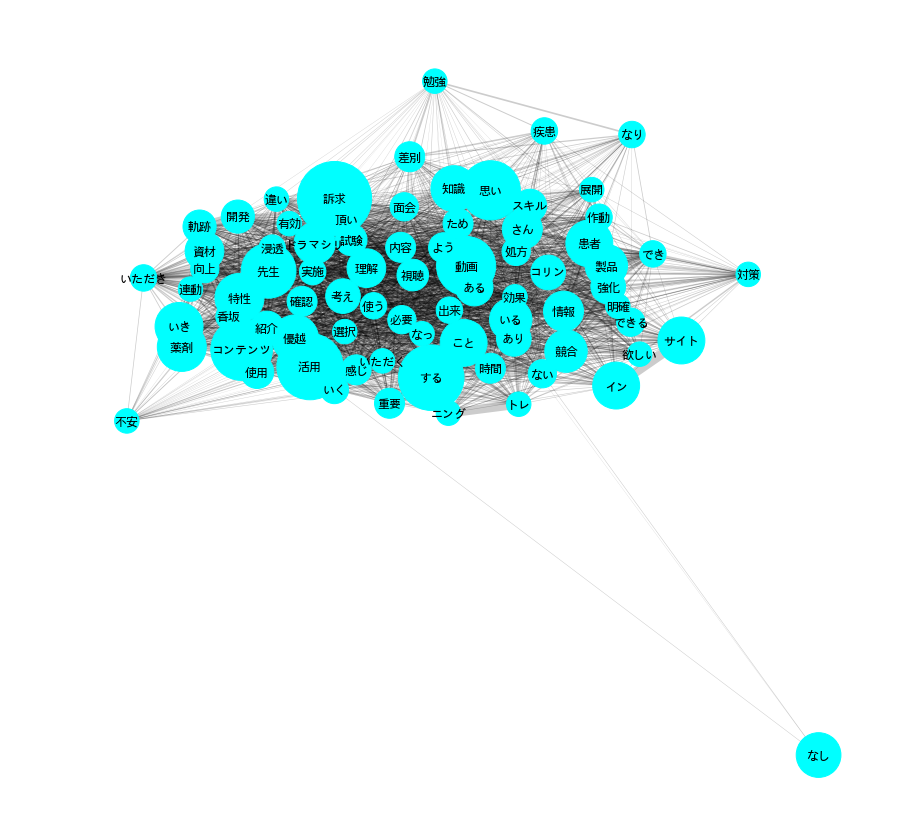

In [111]:
G = nx.Graph()
G.nodes(data=True)

for pair in nodes:
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[0], pair[1], pair[2], pair[3], pair[4]
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
        
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G, k=0.1)

node_size = [d['count']*100 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_color='cyan', alpha=1.0, node_size=node_size)
nx.draw_networkx_labels(G, pos, fontsize=14, font_family='Droid Sans Japanese')

edge_width = [d['weight']*10 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='black', width=edge_width)

plt.axis('off')
plt.show()

In [112]:
wordcloud_text=' '.join(one_word_list)

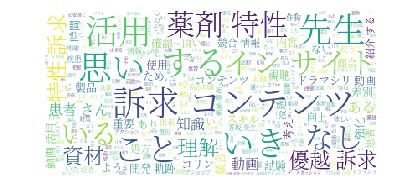

In [113]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def word_cloud(text_list):
#     d = path.dirname(__file__)
    wc = WordCloud(max_words=2000,
                max_font_size=40,
                font_path='../input/chinesewordcloud/SourceHanSerifK-Light.otf',
                background_color='white',
                random_state=42,
                relative_scaling=0)
    wc.generate(text_list)
    # Plot
    plt.figure()
    plt.axis('off')
    plt.imshow(wc)
    plt.show()
word_cloud(wordcloud_text)